Dantion Audio Recognition Model

Import needed library

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

Import dataset

In [2]:
data_dir = 'ML Path/DATASET FINAL'

Defining function to get label and number of files

In [3]:
label = os.listdir(data_dir)
label

['Crash', 'Horn']

In [4]:
def get_numfiles(dir):
    """Get number of files in a directory"""
    count = 0
    for _, _, files in os.walk(dir):
        count += len(files)
    return count

In [5]:
get_numfiles(data_dir)

2317

In [6]:
def get_files(dir):
    '''Get all file path and convert to EagerTensor'''
    filedir = str(dir) + ("/*/*.wav") #Get .wav files directory
    files = tf.io.gfile.glob(filedir) #Returns a list of files that match the given pattern(s)
    files = tf.random.shuffle(files) #Randomly shuffles a tensor along its first dimension
    return files

In [7]:
filenames = get_files(data_dir)

In [8]:
def split_data(data,ratio1,ratio2,ratio3):
    '''Split dataset into desired ratio'''
    if ratio1+ratio2+ratio3 == 100 :
        ratio1 = round(len(data)*ratio1/100)
        ratio2 = round(len(data)*ratio2/100)
        ratio3 = round(len(data)*ratio3/100)
        train_files = data[:ratio1]
        val_files = data[ratio1: ratio1 + ratio2]
        test_files = data[-ratio3:]
    else :
        raise ValueError('Exceeding the limit ratio, the total ratio must be 100% but you got ' + str(ratio1+ratio2+ratio3) + 
    '%')
    return train_files,val_files,test_files

In [9]:
train, val, test = split_data(filenames,80,10,10)

## Read the audio files and their labels

In [10]:
def decode_audio(audio_dir):
  '''Decode .wav Audio into mono Audio Tensor'''
  audio, _ = tf.audio.decode_wav(audio_dir,desired_channels=1) 
  return tf.squeeze(audio, axis=-1)

In [11]:
audio = tf.io.read_file(data_dir + '/crash/crash_1.wav') #Reads the contents of file as tensor
waveform = decode_audio(audio)

In [12]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]

In [13]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path) #Reads the contents of file as tensor
  waveform = decode_audio(audio_binary)
  return waveform, label

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

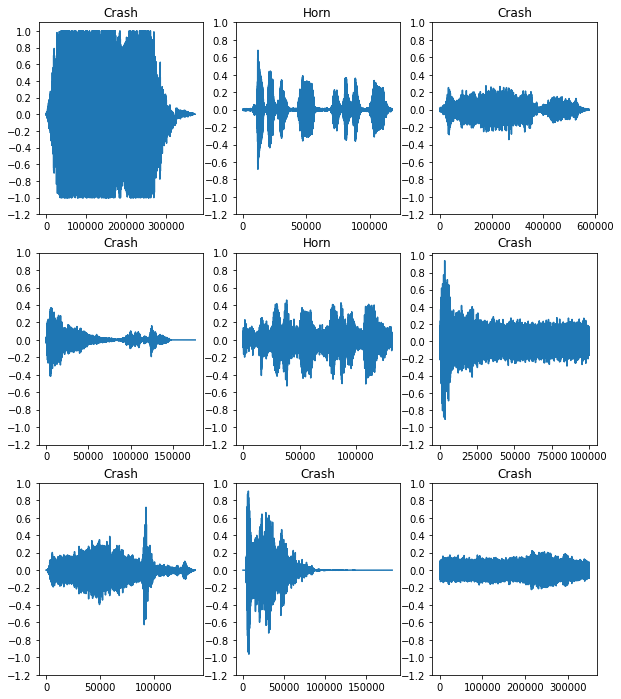

In [15]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [16]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [17]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
#display.display(display.Audio(waveform, rate=16000))

Label: Crash
Waveform shape: (374186,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [18]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

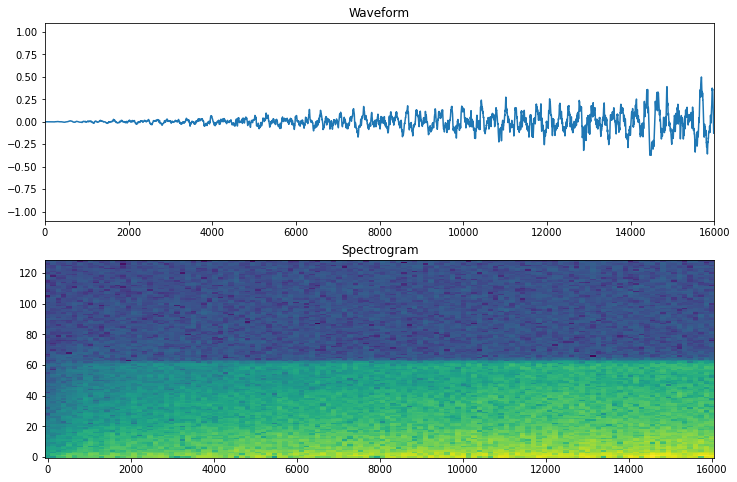

In [19]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [20]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == ['Crash','Horn'])
  return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [21]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

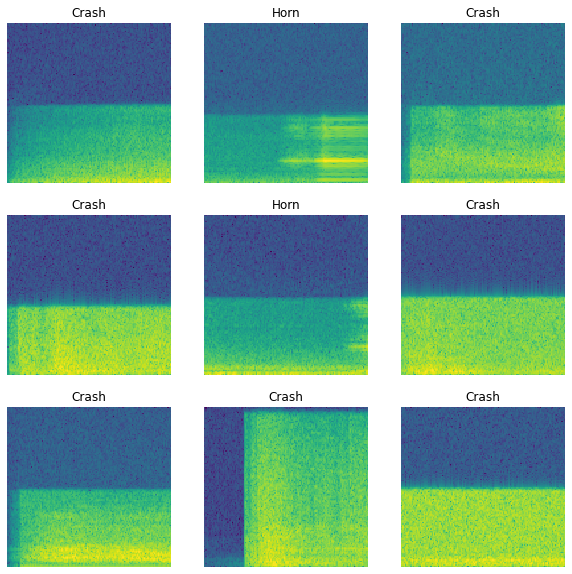

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
commands = ['Crash','Horn']
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [23]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [24]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val)
test_ds = preprocess_dataset(test)

Batch the training and validation sets for model training:

Since you have a pretty small dataset (~ 1000 samples), you would probably be safe using a batch size of 32, which is pretty standard. It won't make a huge difference for your problem unless you're training on hundreds of thousands or millions of observations.

To answer your questions on Batch Size and Epochs:

In general: Larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. It's definitely problem dependent.

In general, the models improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge. Try something like 50 and plot number of epochs (x axis) vs. accuracy (y axis). You'll see where it levels out.

What is the type and/or shape of your data? Are these images, or just tabular data? This is an important detail.

In [25]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [26]:
#parafrase
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

model = models.Sequential()

model.add(layers.Input(shape=input_shape))
    # Downsample the input.
model.add(layers.Conv2D(32, 3, activation='relu', padding='same'))
model.add(layers.MaxPooling2D(padding='same'))
model.add(layers.Conv2D(32, 3, activation='relu', padding='same'))
model.add(layers.MaxPooling2D(padding='same'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_labels, activation = 'softmax'))

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 129, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 65, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 65, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 33, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 31, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling 

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [28]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


c:\Users\Ahmad Ulfi\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


58/58 [==============================] - 38s 639ms/step - loss: 0.2654 - accuracy: 0.8975 - val_loss: 0.0948 - val_accuracy: 0.9698
Epoch 2/10
58/58 [==============================] - 44s 761ms/step - loss: 0.1165 - accuracy: 0.9617 - val_loss: 0.0722 - val_accuracy: 0.9741
Epoch 3/10
58/58 [==============================] - 39s 660ms/step - loss: 0.0942 - accuracy: 0.9703 - val_loss: 0.0819 - val_accuracy: 0.9698
Epoch 4/10
58/58 [==============================] - 38s 656ms/step - loss: 0.0758 - accuracy: 0.9757 - val_loss: 0.0538 - val_accuracy: 0.9698
Epoch 5/10
58/58 [==============================] - 39s 669ms/step - loss: 0.0568 - accuracy: 0.9833 - val_loss: 0.0529 - val_accuracy: 0.9828
Epoch 6/10
58/58 [==============================] - 44s 747ms/step - loss: 0.0559 - accuracy: 0.9811 - val_loss: 0.0450 - val_accuracy: 0.9741
Epoch 7/10
58/58 [==============================] - 44s 746ms/step - loss: 0.0439 - accuracy: 0.9854 - val_loss: 0.0421 - val_accuracy: 0.9871
Epoch 8/10

Let's plot the training and validation loss curves to check how your model has improved during training:

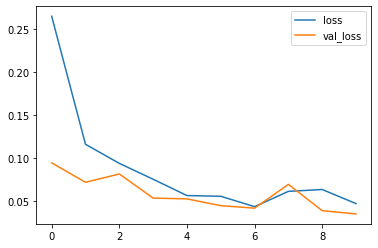

In [29]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [30]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [31]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 99%


### Display a confusion matrix


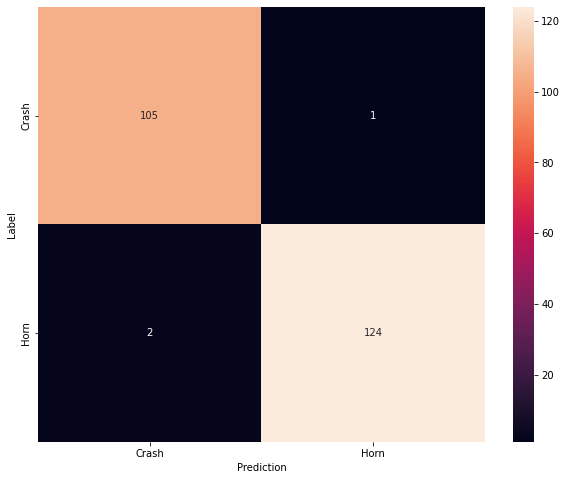

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:

saved_model = 'Text Recognition Tensor/saved_model'
import pathlib

tf.saved_model.save(model,saved_model)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)
tflite_model = converter.convert()
tflite = 'Text Recognition Tensor/saved_model/tmp.tflite'
tflite_model_file = pathlib.Path(tflite)
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: Text Recognition Tensor/saved_model\assets


6502408

In [ ]:
loaded = tf.saved_model.load(saved_model)
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_1': TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input_1')})
{'dense_1': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense_1')}


## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [ ]:
sample_file = data_dir +'/Crash/crash_1.wav'
sample_ds = preprocess_dataset([sample_file])
print(type(sample_ds))

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [41]:
def predicting(path):
    audio = tf.io.read_file(path) #Reads the contents of file as tensor
    waveform = decode_audio(audio)
    spec = get_spectrogram(waveform)
    print(spec.shape)
    return model.predict([spec])

In [42]:
sample_file = data_dir +'/Crash/crash_1.wav'
predicting(sample_file)

(124, 129, 1)


ValueError: in user code:

    File "c:\Users\Ahmad Ulfi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Ahmad Ulfi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Ahmad Ulfi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Ahmad Ulfi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\Users\Ahmad Ulfi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Ahmad Ulfi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 124, 129, 1), found shape=(None, 129, 1)
